In [2]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [3]:
from sklearn.cluster import KMeans, DBSCAN

In [144]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'Spotify_Dataset_V3.csv')
df = pd.read_csv(data_path, delimiter=';')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Day_in_week"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,0,5
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5


# Data Preparation

In [145]:
# Clean - Drop Duplicates
df_clean = df.drop_duplicates(subset=["Date", "id"], keep="last").copy()
df_clean.shape

(467061, 22)

In [146]:
# Filtering out songs that appears less than 14 days
df_appear_count = df_clean.groupby('id').size().reset_index(name='count')
ids_to_be_used = df_appear_count[df_appear_count["count"] > 14]["id"]
df_clean = df_clean[df_clean["id"].isin(ids_to_be_used)]
df_clean.shape

(445363, 22)

In [147]:
df_min_date = df_clean.groupby('id')['Date'].min().reset_index(name='Date')
ids_to_be_used = df_min_date[df_min_date['Date'] < '2023-01-01']['id']
df_clean = df_clean[df_clean["id"].isin(ids_to_be_used)]
df_clean.shape

(437075, 22)

### Day Since Appear

In [148]:
df_points = df_clean[["Points (Total)", "Date", "id"]].copy()
# df_points = df_points[:100000].copy()

# Calculate Day Since Appear
# df_points.sort_values(by=['id', 'Date'], inplace=True)
df_points['day_since_appear'] = df_points.groupby('id')['Date'].transform(lambda x: (x - x.min()).dt.days + 1)

In [149]:
# df_points['Points (Total)'] = pd.cut(df_points["Points (Total)"], bins=10, labels=range(1, 11)).astype(int)

### Fill in 0 for missing "Points (Total)"

In [150]:
day_since_appear = pd.Series(range(1,df_points['day_since_appear'].max()))
uuids = df_points["id"].unique()

all_combinations = pd.MultiIndex.from_product([uuids, day_since_appear], names=['id', 'day_since_appear'])
full_df = pd.DataFrame(index=all_combinations).reset_index()

merged_df = pd.merge(full_df, df_points, on=['id', 'day_since_appear'], how='left')
merged_df['Points (Total)'].fillna(0, inplace=True)
merged_df.head()

,id,day_since_appear,Points (Total),Date
0,1Qrg8KqiBpW07V7PNxwwwL,1,196.0,2022-12-09
1,1Qrg8KqiBpW07V7PNxwwwL,2,193.0,2022-12-10
2,1Qrg8KqiBpW07V7PNxwwwL,3,194.0,2022-12-11
3,1Qrg8KqiBpW07V7PNxwwwL,4,199.0,2022-12-12
4,1Qrg8KqiBpW07V7PNxwwwL,5,200.0,2022-12-13


<Axes: xlabel='day_since_appear', ylabel='Points (Total)'>

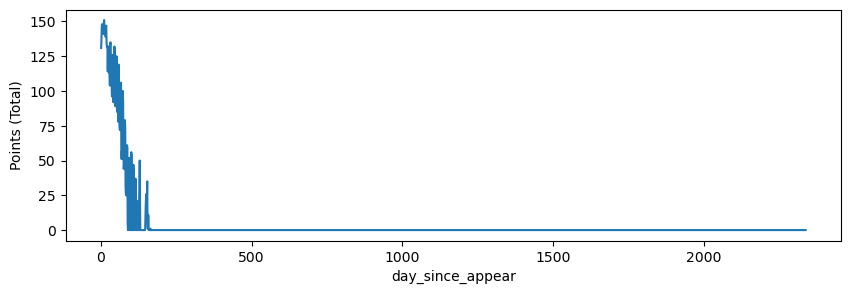

In [151]:
# Random song & Plot Popularity over time
plt.figure(figsize=(10,3))
sample = merged_df.sample(n=1).iloc[0]
sns.lineplot(merged_df[merged_df["id"] == sample["id"]], x="day_since_appear", y="Points (Total)")

In [152]:
# Pivot the DataFrame for clustering
pivot_df = merged_df.pivot(index='id', columns='day_since_appear', values='Points (Total)')
df_smoothed = pivot_df.apply(lambda row: row.rolling(window=7, step=7, min_periods=1).mean(), axis=1)
df_smoothed

day_since_appear,1,8,15,22,29,36,43,50,57,64,...,2276,2283,2290,2297,2304,2311,2318,2325,2332,2339
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,151.0,150.428571,151.571429,147.000000,136.142857,144.285714,144.285714,139.000000,132.285714,127.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,6.0,1.857143,1.000000,2.000000,0.142857,0.285714,0.000000,0.000000,1.142857,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,193.0,190.000000,185.000000,180.285714,172.285714,152.857143,151.714286,127.428571,143.142857,165.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,11.0,49.285714,90.285714,90.142857,106.857143,114.571429,131.285714,131.428571,131.000000,126.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,96.0,122.428571,43.857143,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7yq4Qj7cqayVTp3FF9CWbm,1.0,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7ytR5pFWmSjzHJIeQkgog4,192.0,187.428571,185.571429,193.000000,196.285714,198.857143,198.857143,199.857143,199.857143,199.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7yyRTcZmCiyzzJlNzGC9Ol,170.0,155.142857,153.285714,148.571429,138.428571,135.428571,130.571429,124.428571,98.285714,98.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
pivot_df_norm = df_smoothed.T
pivot_df_norm = (pivot_df_norm-pivot_df_norm.min())/(pivot_df_norm.max()-pivot_df_norm.min())
# pivot_df_norm = (pivot_df_norm-pivot_df_norm.mean())/pivot_df_norm.std()
pivot_df_norm = pivot_df_norm.T
pivot_df_norm

day_since_appear,1,8,15,22,29,36,43,50,57,64,...,2276,2283,2290,2297,2304,2311,2318,2325,2332,2339
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,0.996230,0.992460,1.000000,0.969840,0.898209,0.951932,0.951932,0.917059,0.872762,0.839774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,0.086598,0.026804,0.014433,0.028866,0.002062,0.004124,0.000000,0.000000,0.016495,0.014433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,1.000000,0.984456,0.958549,0.934123,0.892672,0.792006,0.786084,0.660252,0.741673,0.856403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,0.083696,0.375000,0.686957,0.685870,0.813043,0.871739,0.998913,1.000000,0.996739,0.961957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,0.784131,1.000000,0.358226,0.001167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7yq4Qj7cqayVTp3FF9CWbm,0.009831,0.004213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7ytR5pFWmSjzHJIeQkgog4,0.960000,0.937143,0.927857,0.965000,0.981429,0.994286,0.994286,0.999286,0.999286,0.998571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7yyRTcZmCiyzzJlNzGC9Ol,1.000000,0.912605,0.901681,0.873950,0.814286,0.796639,0.768067,0.731933,0.578151,0.578992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
selected_columns = pivot_df_norm.columns[:57]
pivot_df_norm = pivot_df_norm[selected_columns]

In [182]:
# pivot_df.to_csv("date_point_pop_only.csv")

In [192]:
# Calculate Differentitate
df_diff = pivot_df_norm.diff(axis=1)
df_diff.drop(columns=1, inplace=True)
df_diff.head()

day_since_appear,8,15,22,29,36,43,50,57,64,71,...,330,337,344,351,358,365,372,379,386,393
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,-0.003770,0.007540,-0.030160,-0.071631,0.053723,0.000000,-0.034873,-0.044298,-0.032988,-0.383600,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
003vvx7Niy0yvhvHt4a68B,-0.059794,-0.012371,0.014433,-0.026804,0.002062,-0.004124,0.000000,0.016495,-0.002062,-0.014433,...,0.257732,-0.181443,0.057732,-0.05567,-0.078351,0.189691,0.045361,-0.101031,-0.474227,-0.006186
00Blm7zeNqgYLPtW6zg8cj,-0.015544,-0.025907,-0.024426,-0.041451,-0.100666,-0.005922,-0.125833,0.081421,0.114730,-0.031828,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00EPIEnX1JFjff8sC6bccd,0.291304,0.311957,-0.001087,0.127174,0.058696,0.127174,0.001087,-0.003261,-0.034783,-0.044565,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00ko9WaS4jOX1kEk3gvHjf,0.215869,-0.641774,-0.357060,-0.001167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: xlabel='day_since_appear', ylabel='15xWRPHQMeqgdkGzInx3PY'>

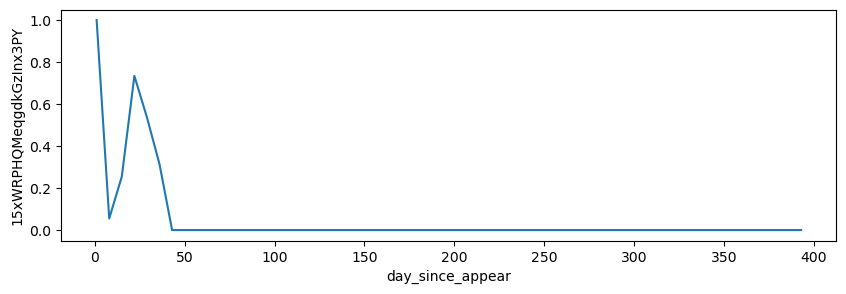

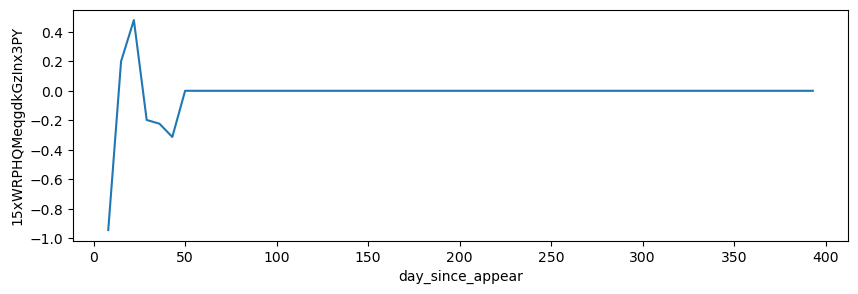

In [193]:
sample = pivot_df_norm.sample(n=1)
sample_id = sample.index[0]

plt.figure(figsize=(10,3))
sns.lineplot(sample.iloc[0])

# plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(df_diff.loc[sample_id])

# Song Popularity Over time

In [134]:
# all time hit, 6RUKPb4LETWmmr3iAEQktW, 5uCax9HTNlzGybIStD3vDh
# old release, but popular in 2022, 4xkOaSrkexMciUUogZKVTS, 4UKCKdYiLN6IMA5ZESUTL7, 1kKYjjfNYxE0YYgLa7vgVY
# popu. on and off, 2jyjhRf6DVbMPU5zxagN2h, 60a0Rd6pjrkxjPbaKzXjfq
# popu. on festival, 2TE4xW3ImvpltVU0cPcKUn, 15coTBAzEN1bOeipoNDZAR

id: 7zVCrzzEJU7u24sbJPXA5W | Total count: 28
Song: What Ifs (feat. Lauren Alai) | Artists: Kane Brown | Continent: Anglo-America


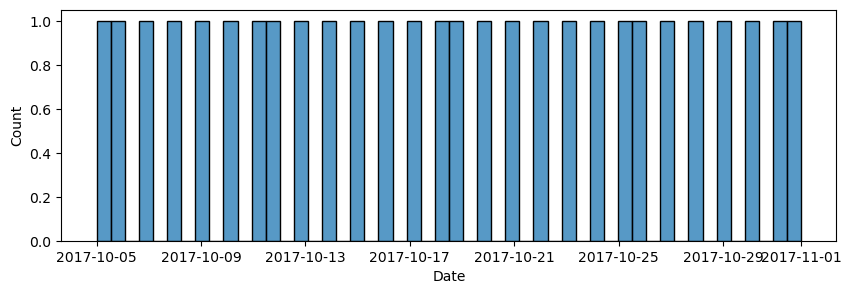

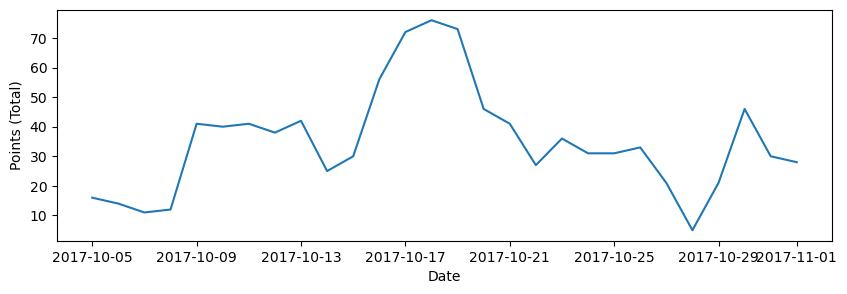

<Axes: xlabel='day_since_appear', ylabel='7zVCrzzEJU7u24sbJPXA5W'>

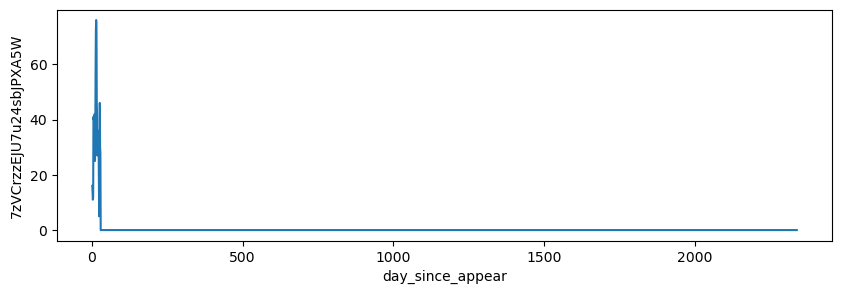

In [45]:
# sample = df_clean.sample(n=1).iloc[0]
sample = df_clean[df_clean["id"] == "7zVCrzzEJU7u24sbJPXA5W"].iloc[0]
df_focus = df_clean[df_clean["id"] == sample["id"]]

print(f'id: {sample["id"]} | Total count: {df_focus.shape[0]}')
print(f'Song: {sample["Title"]} | Artists: {sample["Artists"]} | Continent: {sample["Continent"]}')

# Histogram
plt.figure(figsize=(10, 3))
sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(pivot_df.loc[sample["id"]])


# Clustering

In [30]:
# # df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
# df_cluster_original = pivot_df.copy()

# dbscan = DBSCAN(eps=100)
# dbscan.fit(df_cluster_original)

# df_cluster = df_cluster_original.copy()
# df_cluster['cluster'] = dbscan.labels_
# labels = dbscan.labels_

# # pca = PCA(n_components=4)  # Reduce to 2 dimensions
# # X_2d = pca.fit_transform(df_cluster_original)

# # plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

# plt.figure(figsize=(8, 3))
# sns.histplot(df_cluster["cluster"])

0.07981304968826426


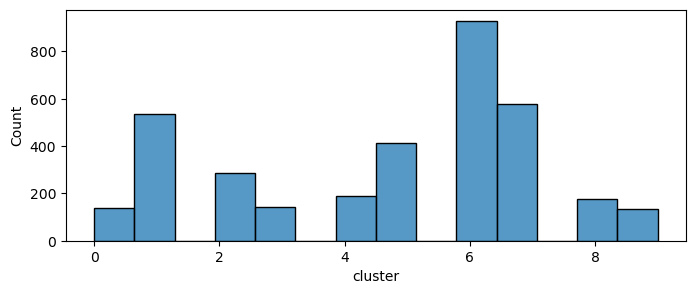

In [194]:
# df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
df_cluster_original = df_diff.copy()

kmeans = KMeans(n_clusters=10, n_init="auto", max_iter=300)
kmeans.fit(df_cluster_original)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = kmeans.labels_
labels = kmeans.labels_

# pca = PCA(n_components=4)  # Reduce to 2 dimensions
# X_2d = pca.fit_transform(df_cluster_original)

# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

plt.figure(figsize=(8, 3))
sns.histplot(df_cluster["cluster"])

from sklearn.metrics import silhouette_score
sil_coeff = silhouette_score(df_cluster.drop(columns = 'cluster'),df_cluster['cluster'])
print(sil_coeff)

In [ ]:
# Ideas for future improvements to our clustering:
# - Much of our clustering seems to be done depending on how many of the weeks have 0 points. These weeks make up a large proportion of the data so are weighted heavily. Therefore for many songs with shorter successes the actual shape of the popularity graph is ignored.
# - To combat this we considered normalising the 'day since appear' axis to only range from the first point-scoring week to the last point-scoring week. However this loses information on the duration of popularity and we saw that when the x-axis is stretched/compressed in this way the popularity graphs of 'Alltime hits' and 'Viral hits' were very similar, so we lose this distinction
# - A better option is to summarise the popularity profile into some metrics that are representative of the shape of the chart. For example: duration of popularity, number of peaks, popularity in week X, differential (trend) of popularity in week Y, time between peaks (to identify 'Periodic' hits that will peak every 365 days)


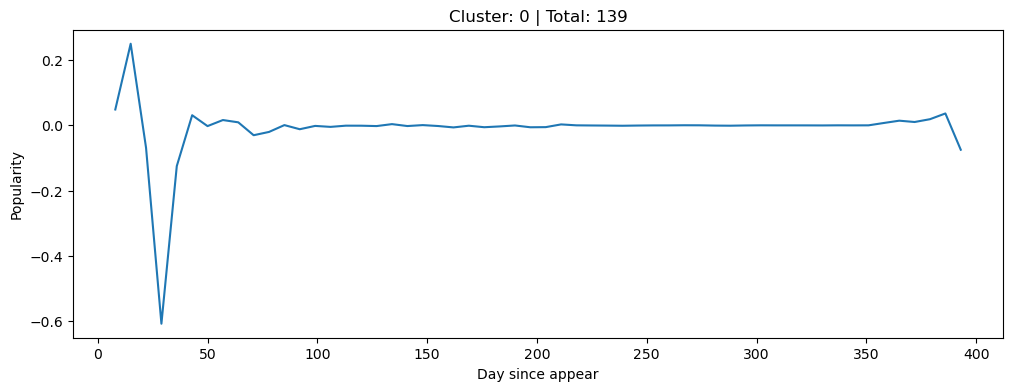

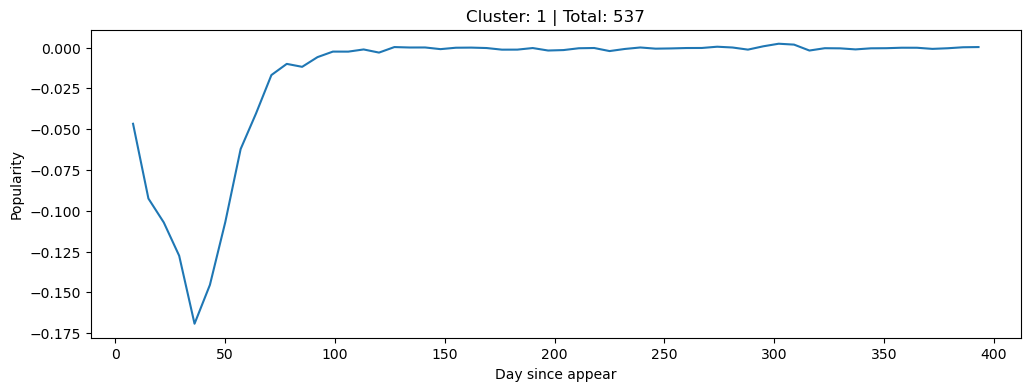

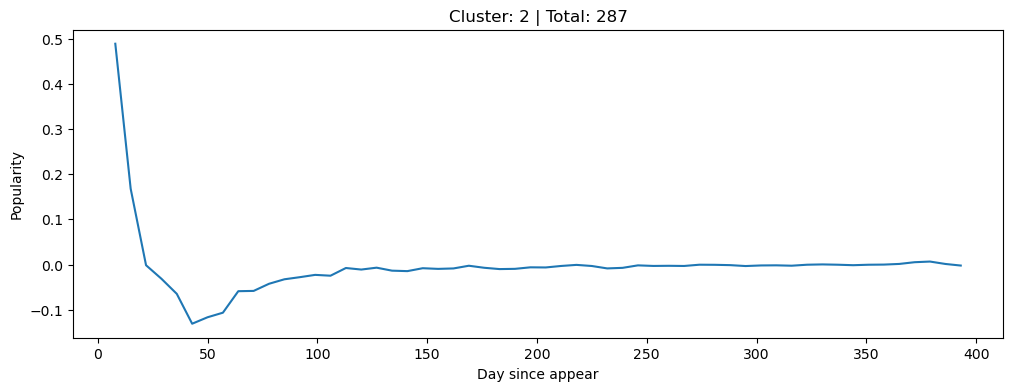

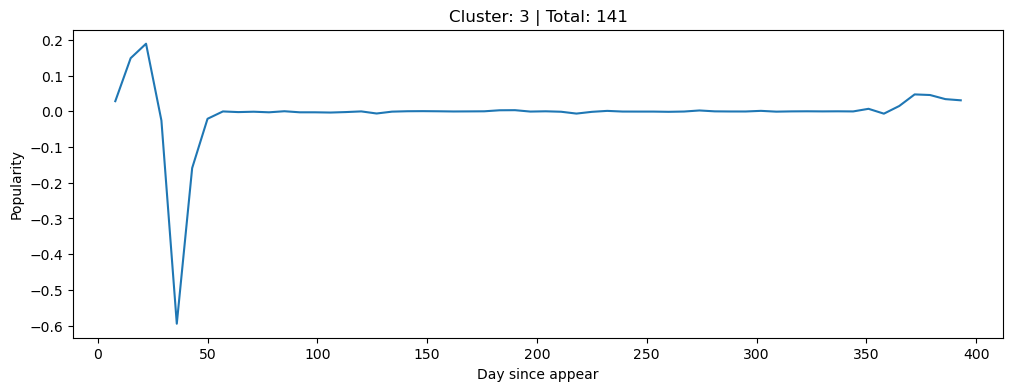

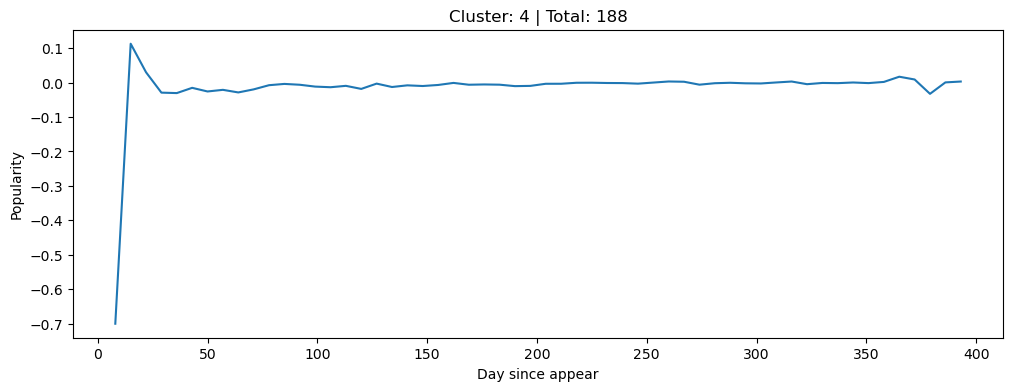

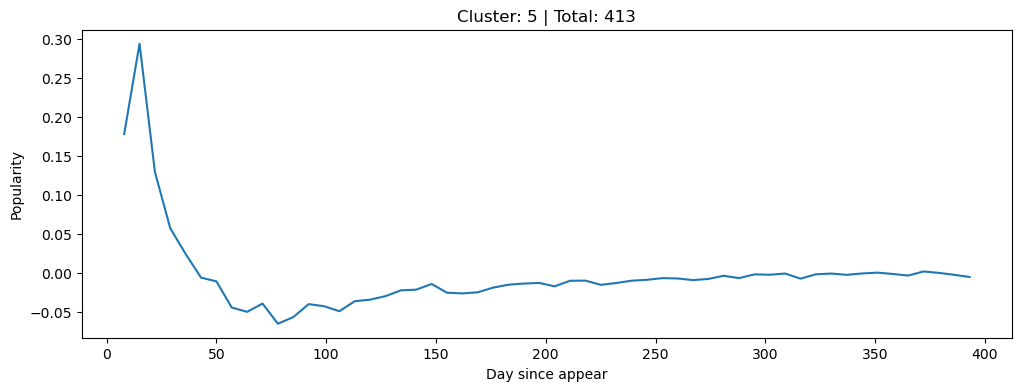

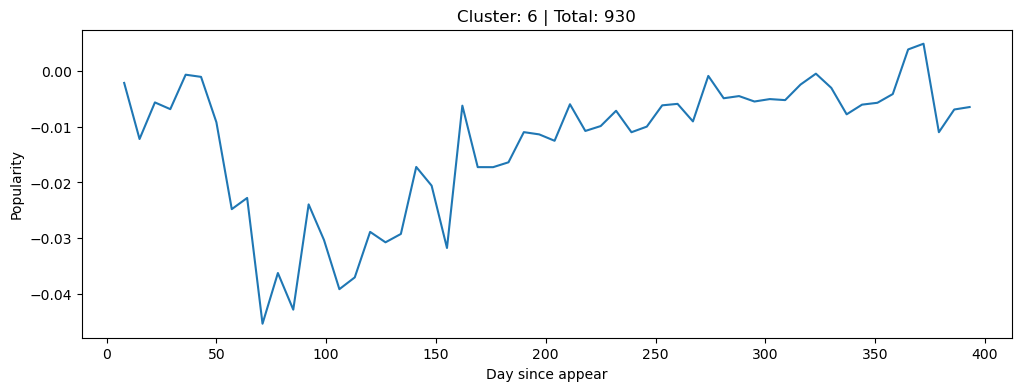

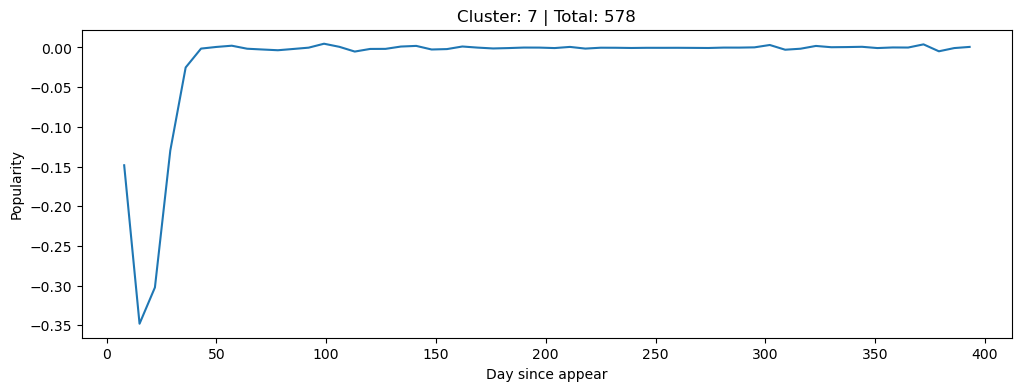

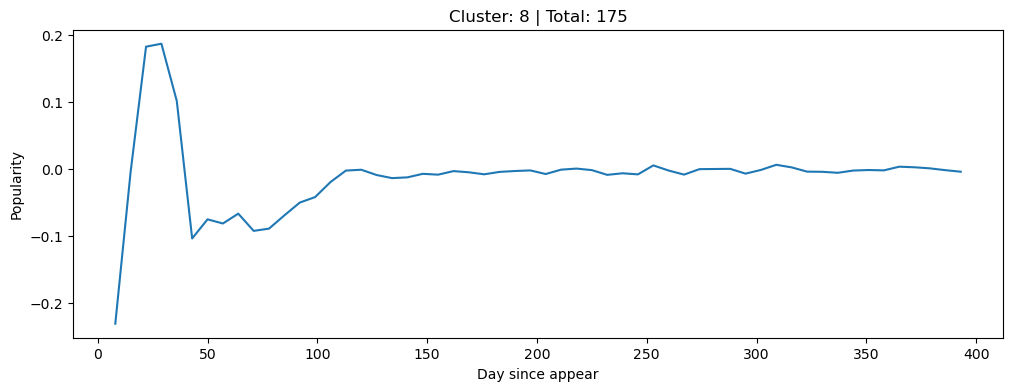

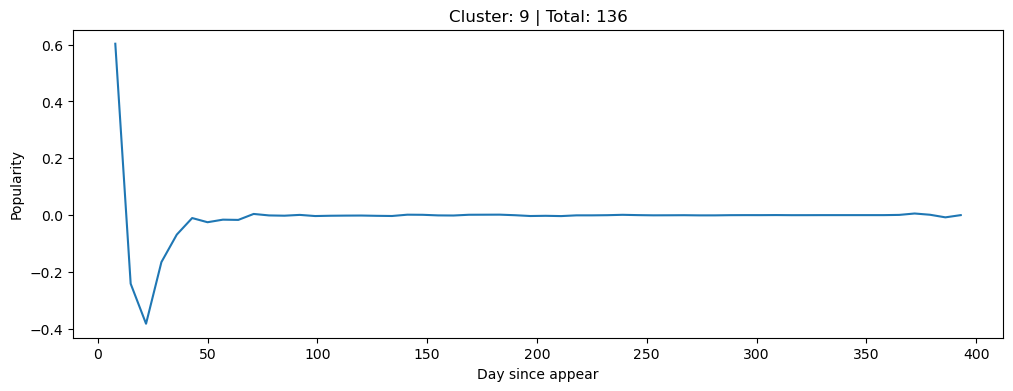

In [195]:
for cluster in sorted(df_cluster["cluster"].unique()):
    cluster_size = df_cluster[df_cluster["cluster"] == cluster].shape[0]
    sample = df_cluster[df_cluster["cluster"] == cluster]
    df_sample = sample.drop(columns="cluster").mean()

    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(df_sample.T)
    ax.set_title(f'Cluster: {cluster} | Total: {cluster_size}')
    ax.set(xlabel='Day since appear', ylabel='Popularity')
    plt.show()

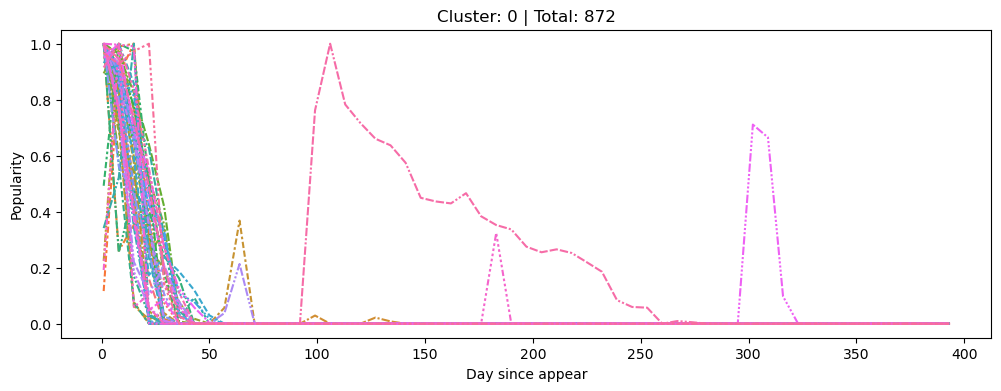

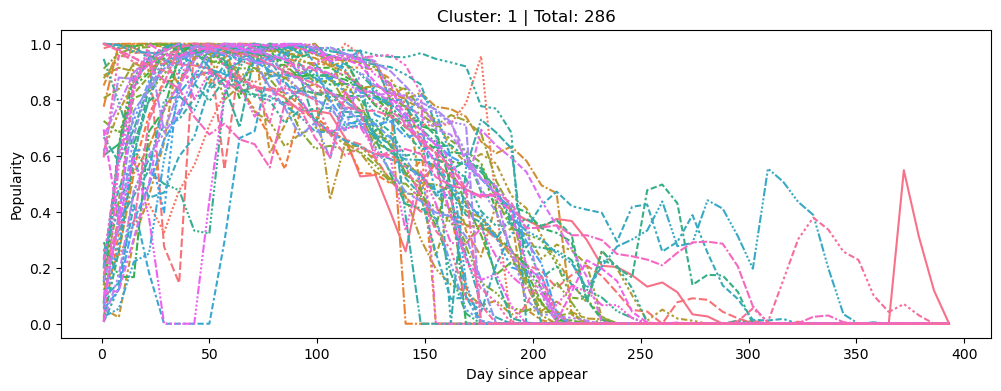

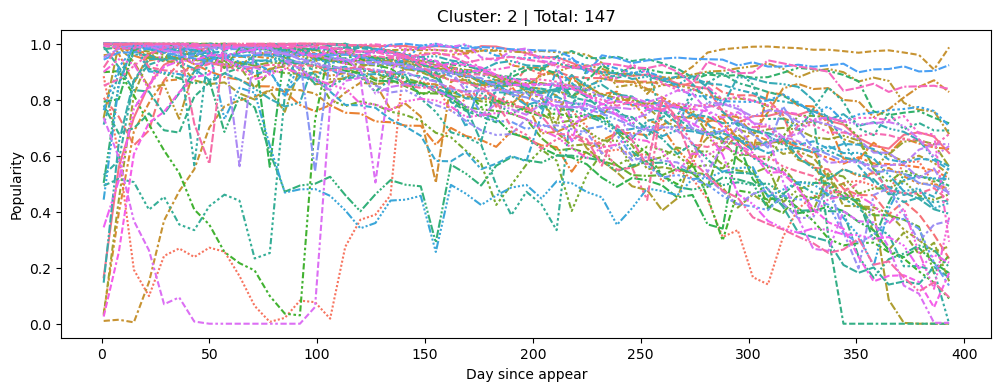

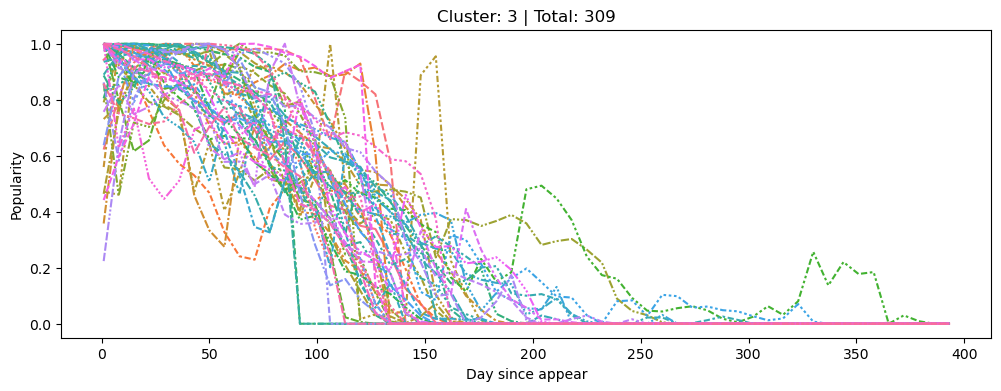

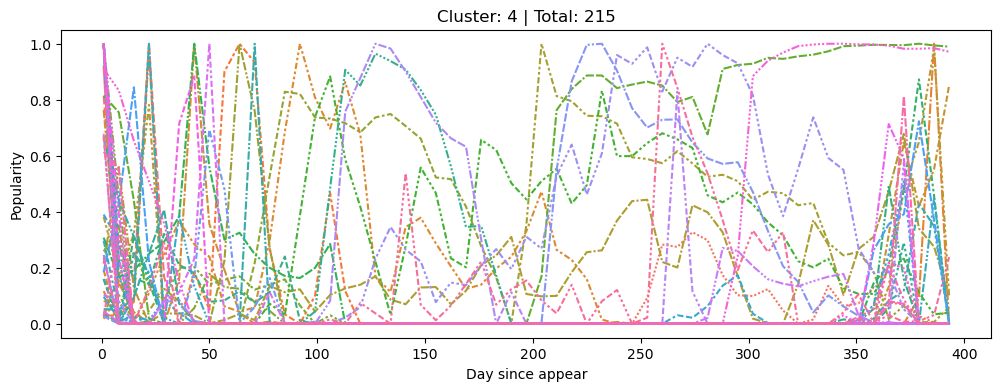

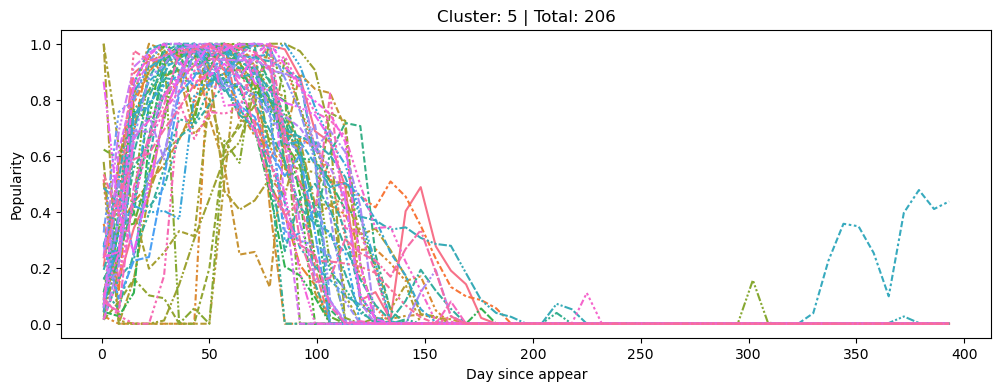

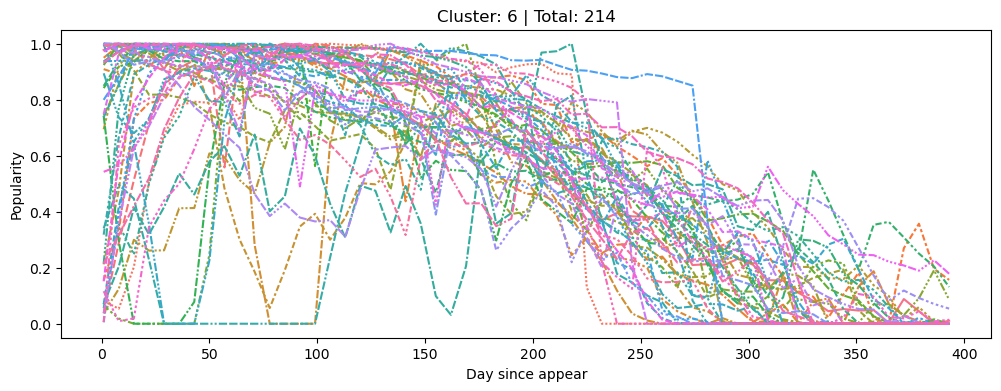

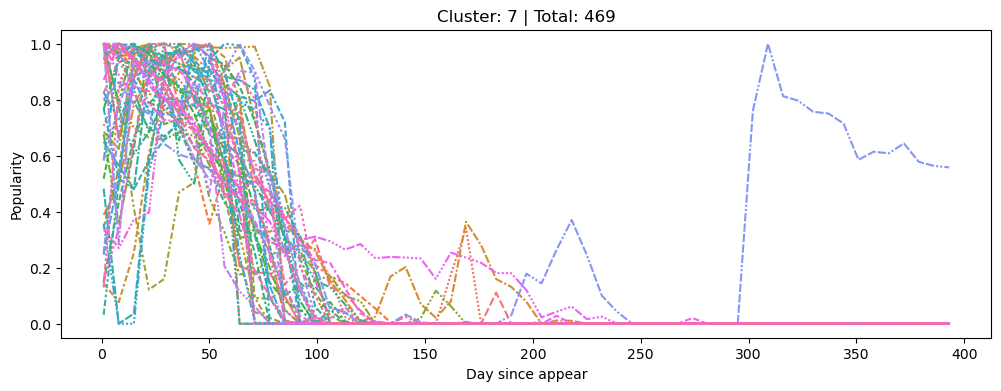

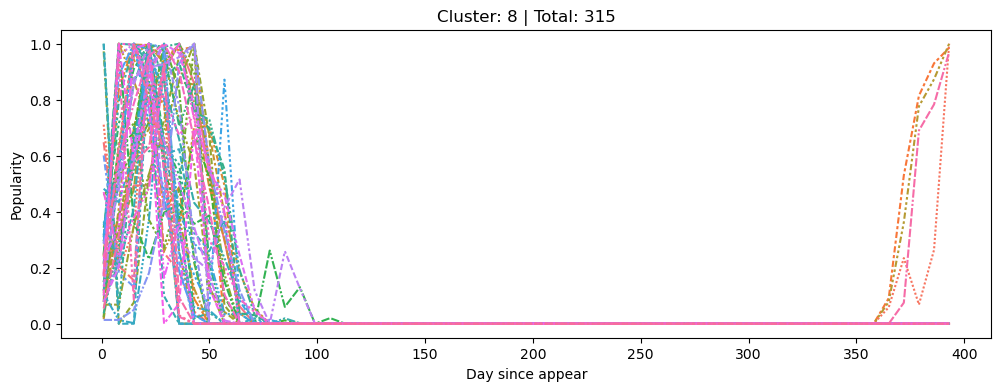

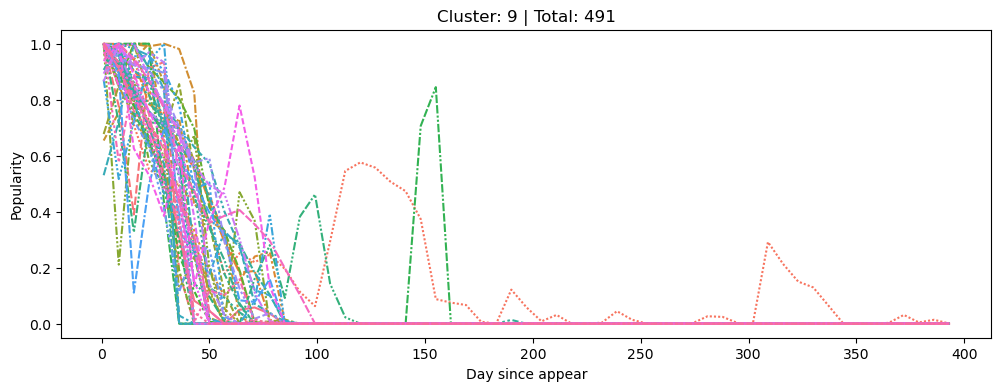

In [190]:
for cluster in sorted(df_cluster["cluster"].unique()):
    cluster_size = df_cluster[df_cluster["cluster"] == cluster].shape[0]
    sample = df_cluster[df_cluster["cluster"] == cluster].sample(min(cluster_size, 50))
    df_sample = sample.drop(columns="cluster")

    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(df_sample.T)
    ax.set_title(f'Cluster: {cluster} | Total: {cluster_size}')
    ax.set(xlabel='Day since appear', ylabel='Popularity')
    ax.get_legend().remove()
    plt.show()

In [43]:
# inspect each cluster
ids_to_be_used = df_cluster[df_cluster["cluster"] == 16].index
df_clean[df_clean["id"].isin(ids_to_be_used)].groupby("id").first()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),Song URL,Day_in_week,Month
id,,,,,,,,,,,,,,,,,,,,,
1kKYjjfNYxE0YYgLa7vgVY,192,Higher Love,"Kygo, Whitney Houston",2021-12-31,0.693,0.678,-7159.0,0.032,0.015,0.000,...,Artist 2,Whitney Houston,Nationality 2,United States,Anglo-America,9,4.5,https://open.spotify.com/track/1kKYjjfNYxE0YYg...,4,12
4UKCKdYiLN6IMA5ZESUTL7,200,the remedy for a broken heart (why am I so in ...,XXXTENTACION,2018-12-11,0.699,0.304,-11192.0,0.099,0.779,0.001,...,Artist 1,XXXTENTACION,Nationality 1,United States,Anglo-America,1,1.0,https://open.spotify.com/track/4UKCKdYiLN6IMA5...,1,12
4xkOaSrkexMciUUogZKVTS,198,'Till I Collapse,"Eminem, Nate Dogg",2023-02-01,0.548,0.847,-3237.0,0.186,0.062,0.000,...,Artist 2,Nate Dogg,Nationality 2,United States,Anglo-America,3,2.0,https://open.spotify.com/track/4xkOaSrkexMciUU...,2,2


# Clustering (Draft, TimeSeriesKMeans)

In [46]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 8.5 MB/s eta 0:00:00a 0:00:01


In [47]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
# df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
df_cluster_original = df_diff.copy()


km = TimeSeriesKMeans(n_clusters=10, metric="dtw")
labels = km.fit_predict(df_cluster_original)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = labels

plt.figure(figsize=(6, 3))
sns.histplot(df_cluster["cluster"])

# Visualise Correlation

In [150]:
df_result = df_clean.drop_duplicates(subset=["id"], keep="last")
df_result = df_result.join(df_cluster[["cluster"]], on='id')
df_result = df_result.join(df_appear_count.set_index('id'), on='id')

df_result = df_result[['id', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'cluster', 'count']].copy()

Text(0.5, 149.72222222222223, 'Cluster')

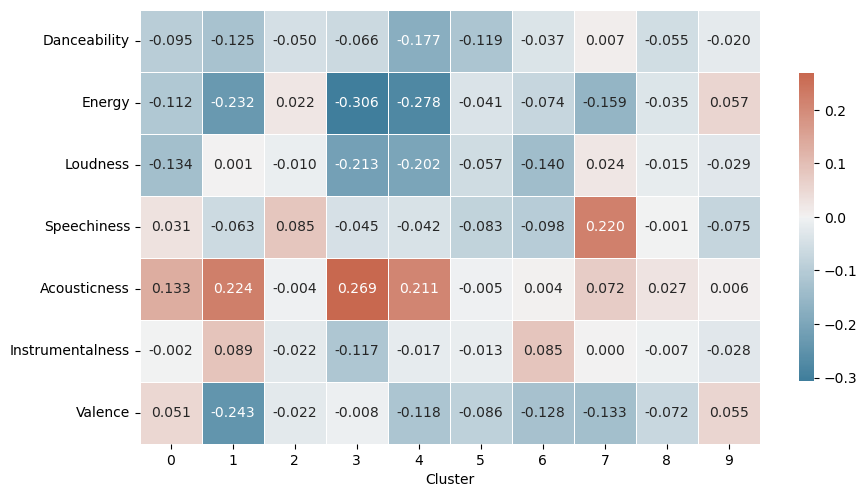

In [151]:
df_raw = df_result.drop(columns=['id']).copy()
df_corr_clus = pd.DataFrame()

for clus in sorted(df_raw["cluster"].unique()):
    df_corr = df_raw[df_raw["cluster"] == clus].drop(columns="cluster").corr()
    df_corr_clus[clus] = df_corr[["count"]].T.drop(columns="count").iloc[0]

# Draw the heatmap
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap((df_corr_clus), cmap=cmap, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.3f')

plt.xlabel("Cluster")